In [1]:
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
import platform

%load_ext autoreload
%autoreload 2

In [2]:
from kalman_steps import *
from helpers import *

In [3]:
TIME_INTERVAL_TO_USE = "1s"
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# Convert the time interval string to a pandas Timedelta object
time_interval = pd.Timedelta(TIME_INTERVAL_TO_USE)
# Extract the total seconds from the Timedelta object and convert to float
time_interval_in_seconds = time_interval.total_seconds()
print(f"Time interval in seconds: {time_interval_in_seconds}")

Time interval in seconds: 1.0


In [4]:
file_identifiers = load_identifiers();
pick_ident = "basak run 01"
file_name = file_identifiers[pick_ident]["file_name"]
file_ident = file_identifiers[pick_ident]
additional_run_info = {}

Identifiers:
0: basak run 02 (run of basak at 31st.))
1: basak run 01 (run of basak at 30th.))
2: my run 01 (my run on the xth of y at xx:yy))
3: my run 02 (my run on the xth of y at xx:yy))


In [5]:
gpx_obj, segment = step_01_load_data(file_name)

/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11238879870.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/hh_marathon.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11238893125_basak02.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11212422262.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro_cleaned.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/3-laender-giro.gpx
/home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11231936537_basak01.gpx
Loading file: /home/dgy/GitHubUbuntU/gps_data_with_python/gpx/activity_11231936537_basak01.gpx
num of tracks=1


## STEP-01 : Initial calculation of up-down hill

In [6]:
segment.get_uphill_downhill()
print_known_info(file_ident, ["total_elevation"])

known total_elevation: 237m


## STEP-02 : Lets find possible paused points 
### according to no info for more than 10 seconds

Training started on 30th of May 2023 at 15:00PM.
Pause point at index 52: Activity time so far: 02'57" seconds
Pause point at index 320: Activity time so far: 15'50" seconds
Pause point at index 487: Activity time so far: 25'12" seconds
Pause point at index 734: Activity time so far: 36'59" seconds
Pause point at index 837: Activity time so far: 41'23" seconds
Pause point at index 1004: Activity time so far: 48'58" seconds
Pause point at index 1053: Activity time so far: 51'40" seconds
Pause point at index 1132: Activity time so far: 55'49" seconds
Pause point at index 1233: Activity time so far: 1:46" seconds
Pause point at index 1243: Activity time so far: 1:01'5" seconds
Pause point at index 1466: Activity time so far: 1:12'42" seconds
Pause point at index 1569: Activity time so far: 1:17'54" seconds
Pause point at index 1694: Activity time so far: 1:24'21" seconds
acttive df = 
    id  first_idx  last_idx  duration  init_second  final_second  tot_activity_time
0    0          0    

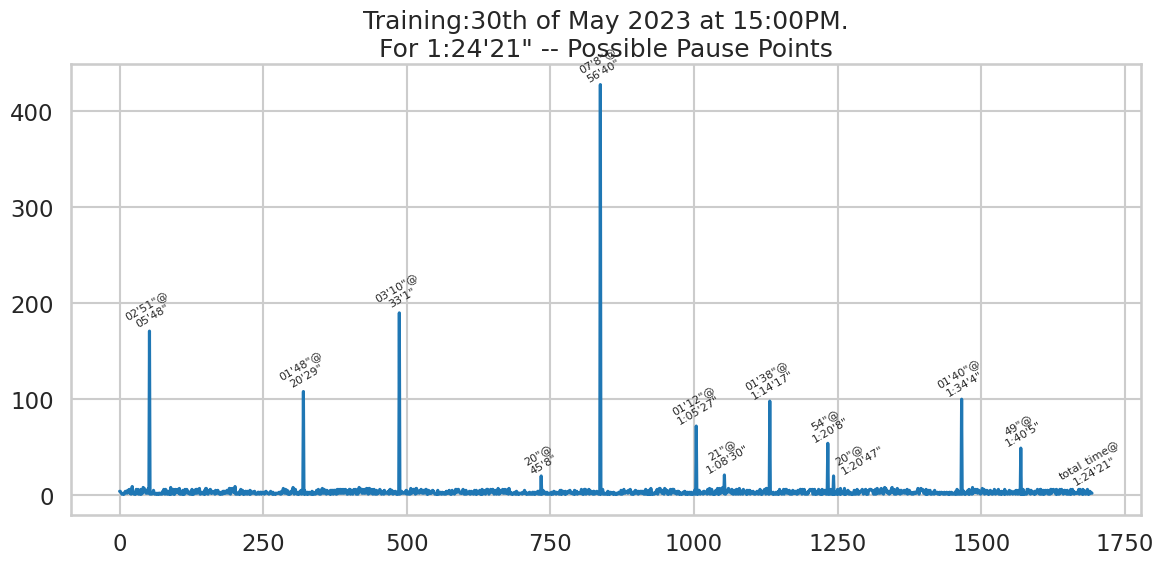

In [20]:
additional_run_info = step_xx0_find_possible_pause_points(segment, additional_run_info, min_pause_time=10, verbose=1, plot_level=1)

In [22]:
# df = pd.DataFrame(additional_run_info["active_df"])
# # Convert DataFrame to a tab-separated string
# df.to_csv("printthis.csv",sep='\t', index=False)

## STEP-03 : Lets find initial speed and distance

In [8]:
speed_dict = {}
step_02_initial_speed(gpx_obj, segment, speed_dict, True)
print_known_info(file_ident, ["active_time", "total_time", "total_distance"])

none_indices = [202 203]
In 1695 points, speed_vincenty=9.73037991415585 and distance_vincenty=14.183 km
known active_time: 1:24:21
known total_time: 1:46:33
known total_distance: 14.00km


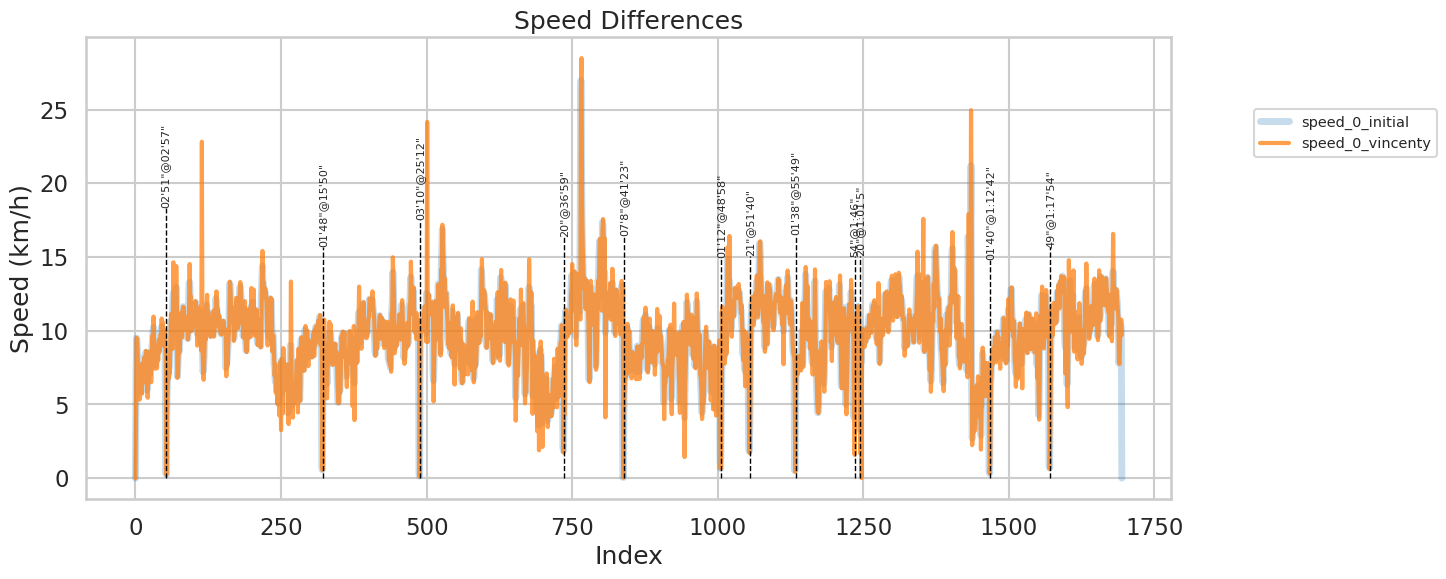

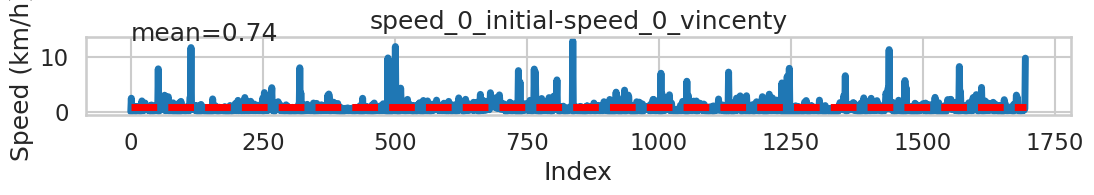

In [9]:
plot_all_keys(speed_dict, additional_run_info)
plot_all_key_difs(speed_dict)

## STEP-04 : Convert segment info to coords

In [10]:
coords = step_03_segments_to_coords_pd(segment)
print(coords.tail(3))

                            idx        lat        lon        ele     speed
time                                                                      
2023-05-30 16:47:05+00:00  1692  41.139045  29.028405  78.400002  2.894838
2023-05-30 16:47:07+00:00  1693  41.139098  29.028391  78.599998  2.849311
2023-05-30 16:47:09+00:00  1694  41.139145  29.028378  78.599998  0.000000


### Oh... time interval is not always 1sec, let's do something about that and round to nearest sec

In [11]:
step_04_round_time(coords, frequency=TIME_INTERVAL_TO_USE)
coords.tail(5)

,idx,lat,lon,ele,speed
time,,,,,
2023-05-30 16:46:59+00:00,1690,41.138913,29.028491,78.000000,2.361259
2023-05-30 16:47:02+00:00,1691,41.138975,29.028445,77.800003,2.734287
2023-05-30 16:47:05+00:00,1692,41.139045,29.028405,78.400002,2.894838
2023-05-30 16:47:07+00:00,1693,41.139098,29.028391,78.599998,2.849311
2023-05-30 16:47:09+00:00,1694,41.139145,29.028378,78.599998,0.000000


### Do we have signal loss?

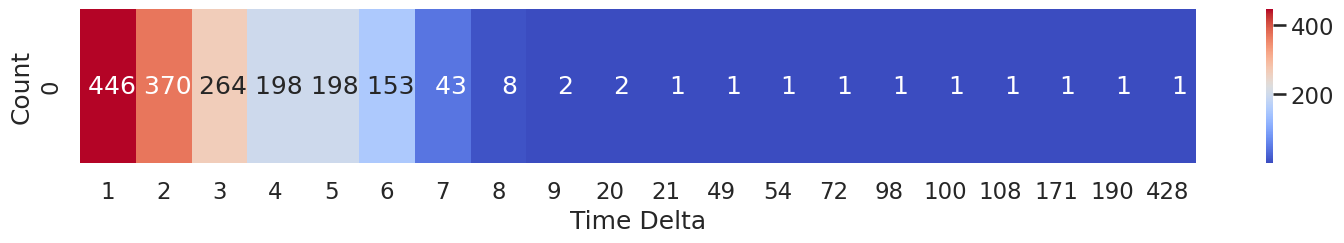

In [12]:
plot_time_dif_counts(coords)

### Okay, let's resample with 1 sec intevals and fill up with NaN

In [13]:
coords = step_05_resample(coords=coords, freq=TIME_INTERVAL_TO_USE)

                           idx        lat        lon        ele    speed
time                                                                    
2023-05-30 15:00:37+00:00  0.0  41.138924  29.030498  82.800003  0.00000
2023-05-30 15:00:38+00:00  NaN        NaN        NaN        NaN      NaN
2023-05-30 15:00:39+00:00  NaN        NaN        NaN        NaN      NaN
2023-05-30 15:00:40+00:00  NaN        NaN        NaN        NaN      NaN
2023-05-30 15:00:41+00:00  1.0  41.138886  29.030534  82.800003  1.97341
                           idx  lat  lon  ele  speed
time                                                
2023-05-30 15:00:38+00:00  NaN  NaN  NaN  NaN    NaN
2023-05-30 15:00:39+00:00  NaN  NaN  NaN  NaN    NaN
2023-05-30 15:00:40+00:00  NaN  NaN  NaN  NaN    NaN
2023-05-30 15:00:42+00:00  NaN  NaN  NaN  NaN    NaN
2023-05-30 15:00:43+00:00  NaN  NaN  NaN  NaN    NaN


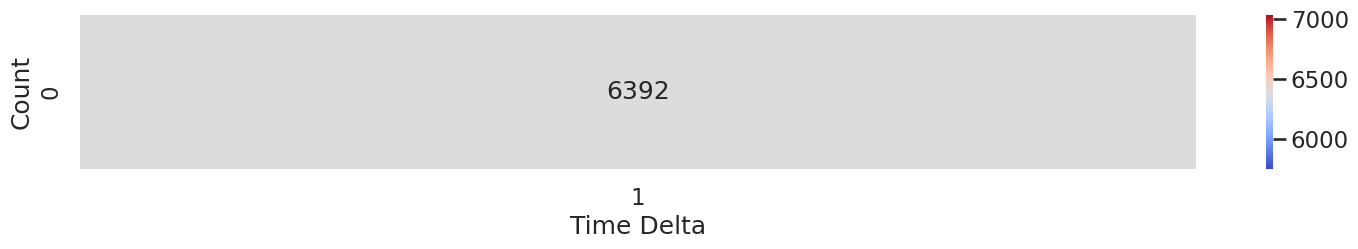

In [14]:
print(coords.loc[:].head())
print(coords.loc[coords.ele.isnull()].head())
plot_time_dif_counts(coords)

### Almost done. Now convert to good old numpy array and mask NaNs

In [19]:
measurements, measurements_df_info = step_06_get_measurements_from_coords(coords, additional_run_info) # lon-0 lat-1 ele-2

### So where did I lose the GPS signal?

In [ ]:
step_07_fill_nan_values(coords, measurements, measurements_df_info, 2);

### Let's set up the Kalman Filter

In [ ]:
kf_list, kf_dict = step_08_setup_kalman_filter(measurements, time_interval_in_seconds)

### Compare now our measurements with a smoothed track

In [ ]:
state_means, state_vars = step_09_apply_kalman(kf_list, measurements)

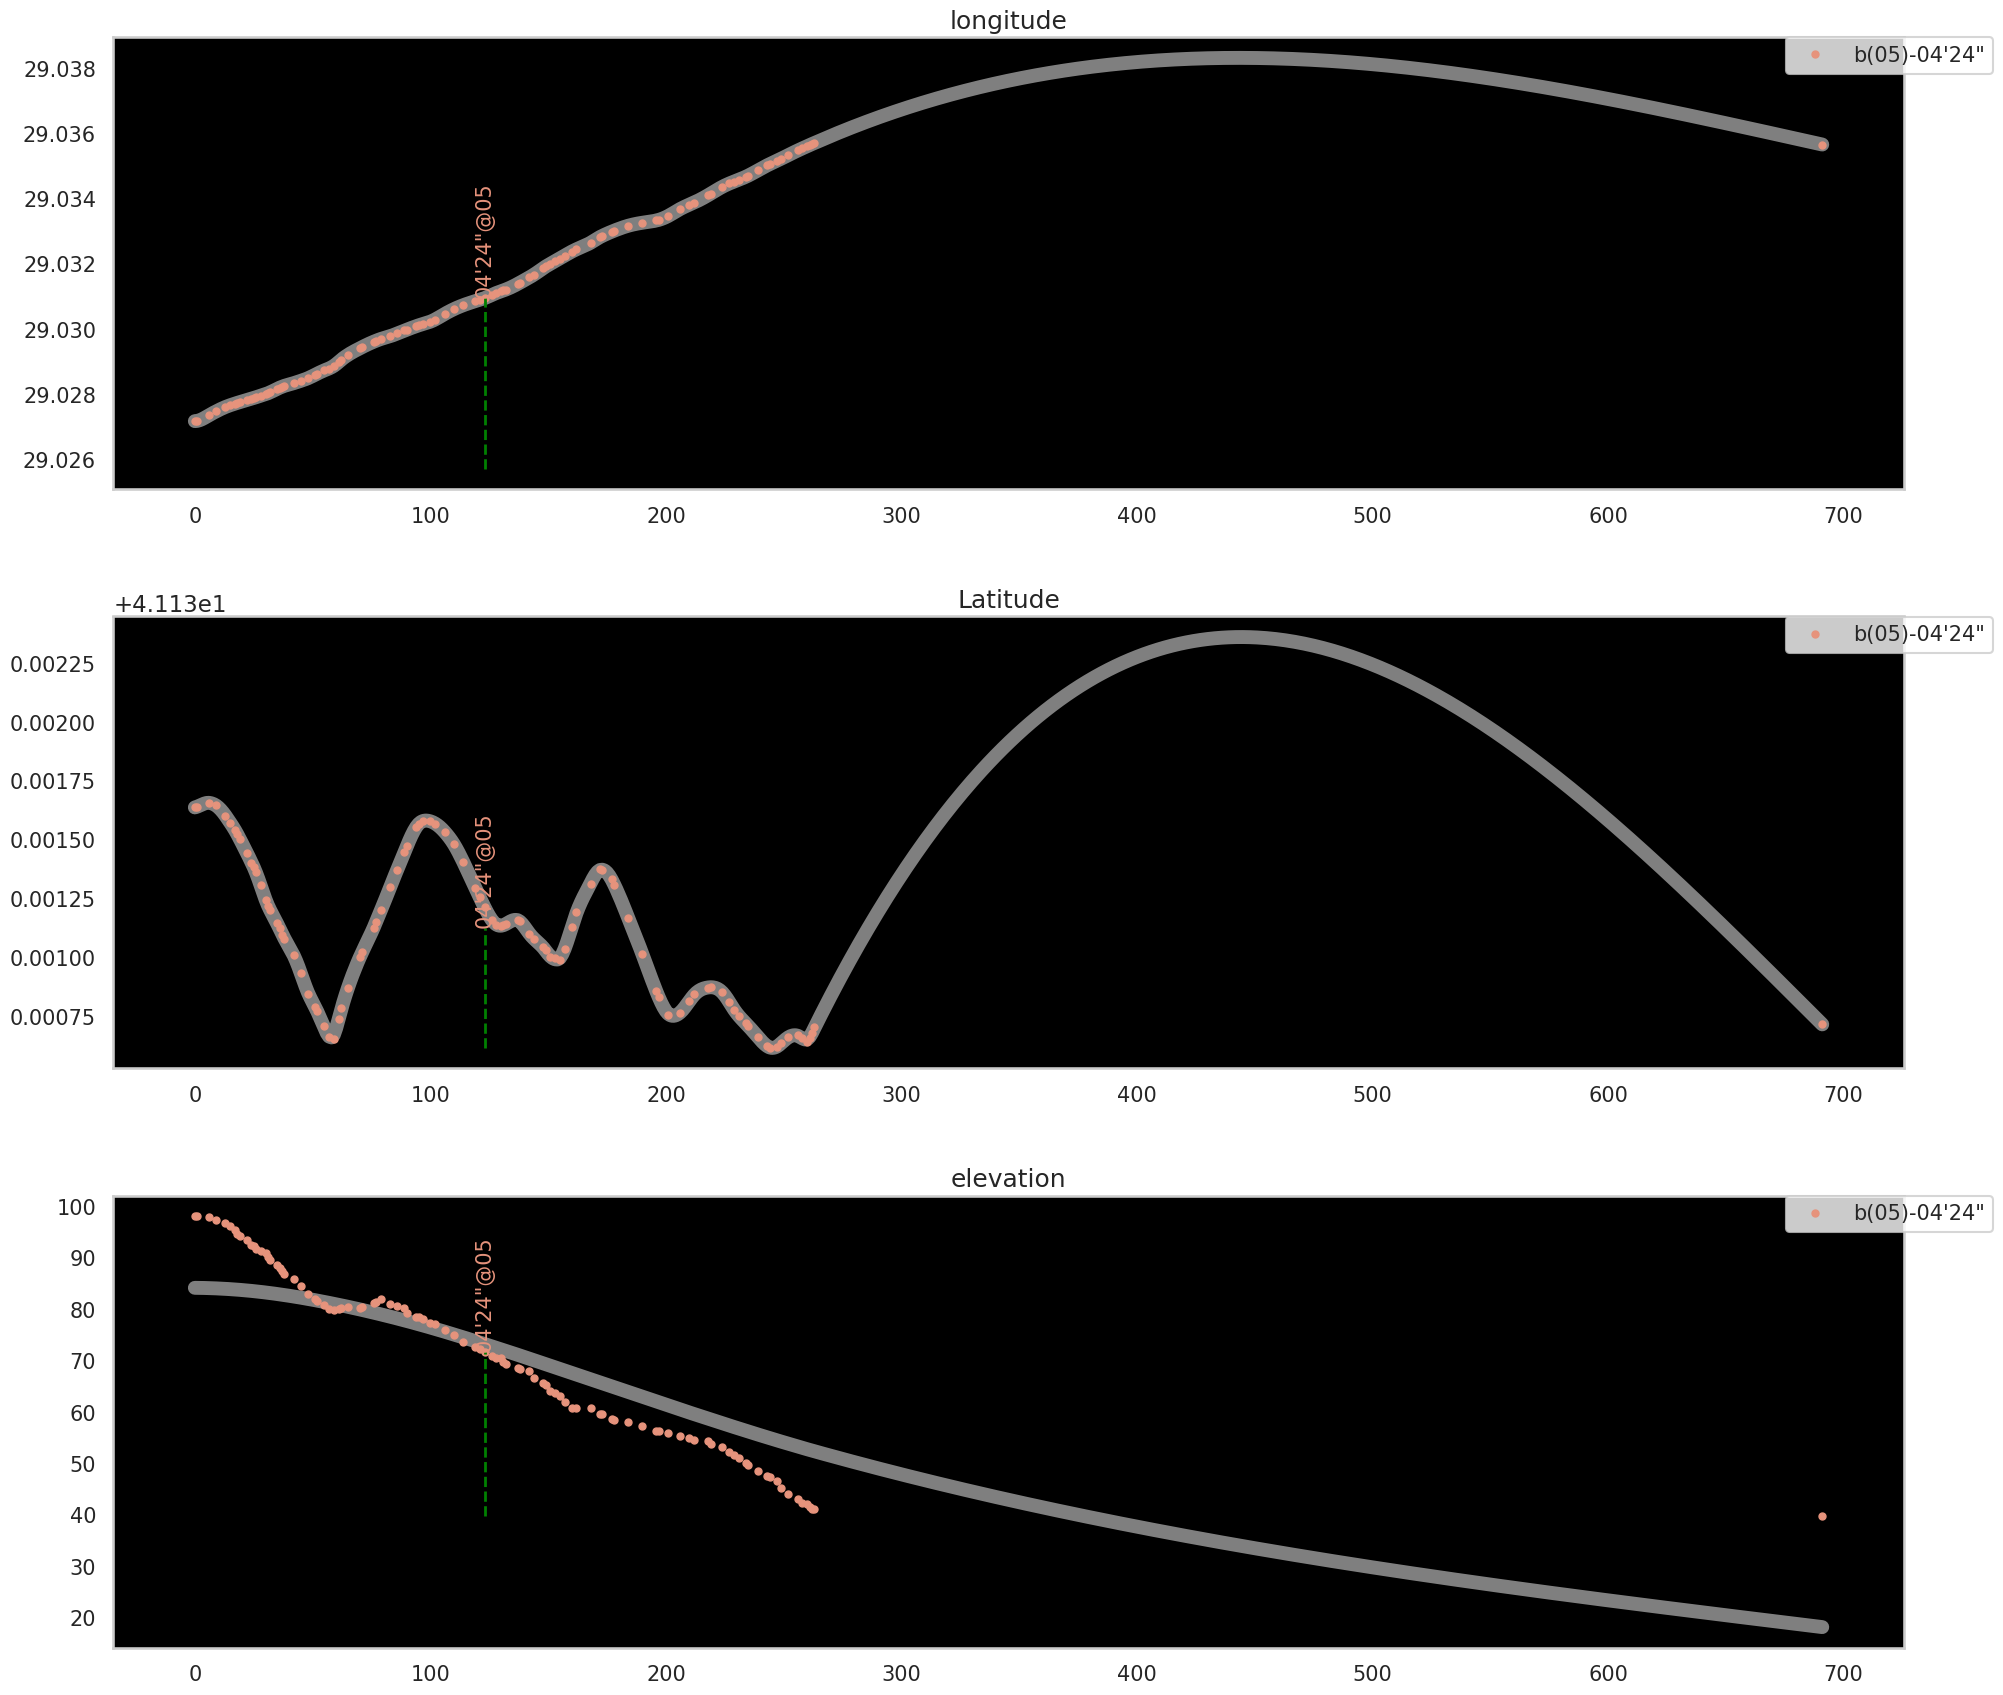

In [37]:
step_10_plot_smoothed_vs_measured(state_means, measurements, measurements_df_info)

### Let's write the smoothed data back into our dataframe and GPX file

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
segment.get_uphill_downhill()

### Yes, that sounds much more realistic!!! Let's also check the speed

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_1_after_kalman', plot_after_add=True)

### Arrrggh!!! Still not good! What the heck is going on?

In [ ]:
plot_all_key_difs(speed_dict)

In [ ]:
high_speed_block = step_13_get_high_speed_block(speed, measurements, segment, plot_result=True, verbose=False)

### Here we have one of the hyperspeed points, so what happens here? Points seem to stack...

### Looking at these numbers the sensors seems to be quite inert! Let's just eliminate unlikely points and their surroundings by using the covariance given by the Kalman filter!

In [ ]:
measurements, bad_readings = step_14_find_bad_readings_from_variance(measurements, state_vars, verbose=True)

In [ ]:
state_means, state_vars = kf.smooth(measurements)

### Write it back our GPX file again

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_2_add_missing', plot_after_add=True)

### We are getting there! Let's take a look where the problem is...

In [ ]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_3_after_calc", measurements, high_speed_block, verbose=False, plot_result=2)

### mmhhh.. okay, that's hard. The GPS sensor has fallen behind in a curve, followed by "normal" readings then has caught up with the actual position

In [ ]:
outliers_idx = step_18_check_for_outliers_by_strong_accelerations(speed_dict["speed_3_after_calc"], measurements, plot_result=True)

### Okay, let's just remove those points with surroundings and let Kalman do the rest

In [ ]:
state_means, state_vars, measurements = step_19_mask_around_outliers(kf, measurements, outliers_idx, neighbour_cnt=12)

In [ ]:
state_means, state_vars = step_20_apply_kalman(state_means, state_vars, kf, n_times=20)

In [ ]:
step_17_21_calc_speed_with_corrected_positions(state_means, speed_dict, "speed_4_after_calc20", measurements, high_speed_block, verbose=False, plot_result=1)

In [ ]:
plot_all_keys(speed_dict,fr_to=[min(high_speed_block),max(high_speed_block)])
#plt.plot(speed_dict["speed_4_after_calc20"][min(use_sub_arr):max(use_sub_arr)], '.')

In [ ]:
plt.plot(measurements[high_speed_block,0], measurements[high_speed_block,1], 'ro', label='measured', markersize=10)
plt.plot(state_means[high_speed_block,0], state_means[high_speed_block,1], 'g.',label='smoothed', markersize=8)
plt.legend()
plt.show()

In [ ]:
coords, orig_coords = step_11_15_22_update_coords(state_means, coords, segment, original_coords_idx)

In [ ]:
segment.get_uphill_downhill()

### Finally, write everything back to the GPX file

In [ ]:
speed = step_12_16_23_add_missing_speeds(gpx_obj, segment, speed_dict, 'speed_5_after_final', plot_after_add=True)

In [ ]:
plot_all_key_difs(speed_dict)

In [ ]:
step_10_plot_smoothed_vs_measured(state_means, measurements)

1- kalman filtreye girdiğinde state_means üzerinden distance toplamına odaklan\n
   ne kadar değişiyor her iiterasyonda \n
2- aynı zamanda elevation da\n
   elevation smooth ettikçe azalıyor - bir hata var o işte\n
3- bir de elevation bilgisini gps bilgisinden alma vardı. o nerede?\n
4- niye 3600 elemanlı veri var? 

In [ ]:
#with open('../gpx/3-laender-giro_cleaned.gpx', 'w') as fh:
#    fh.write(gpx_file.to_xml())